# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-2, 1e-3, 1e-4]
regularization_strengths = [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 9.009410
iteration 100 / 1500: loss 3.041092
iteration 200 / 1500: loss 2.988624
iteration 300 / 1500: loss 2.750911
iteration 400 / 1500: loss 3.178137
iteration 500 / 1500: loss 3.146715
iteration 600 / 1500: loss 2.695800
iteration 700 / 1500: loss 2.912707
iteration 800 / 1500: loss 3.522884
iteration 900 / 1500: loss 2.680844
iteration 1000 / 1500: loss 3.150406
iteration 1100 / 1500: loss 3.560561
iteration 1200 / 1500: loss 2.767372
iteration 1300 / 1500: loss 3.067610
iteration 1400 / 1500: loss 2.871901
iteration 0 / 1500: loss 9.000677
iteration 100 / 1500: loss 3.308406
iteration 200 / 1500: loss 3.126384
iteration 300 / 1500: loss 3.443538
iteration 400 / 1500: loss 3.702326
iteration 500 / 1500: loss 4.257493
iteration 600 / 1500: loss 3.654723
iteration 700 / 1500: loss 3.045182
iteration 800 / 1500: loss 3.802461
iteration 900 / 1500: loss 3.774750
iteration 1000 / 1500: loss 3.510464
iteration 1100 / 1500: loss 3.964353
iteration 1200 / 1500: lo

iteration 300 / 1500: loss 3.901391
iteration 400 / 1500: loss 4.191293
iteration 500 / 1500: loss 4.146229
iteration 600 / 1500: loss 3.876521
iteration 700 / 1500: loss 4.076442
iteration 800 / 1500: loss 3.919295
iteration 900 / 1500: loss 3.954948
iteration 1000 / 1500: loss 4.310940
iteration 1100 / 1500: loss 4.021477
iteration 1200 / 1500: loss 4.039949
iteration 1300 / 1500: loss 3.600785
iteration 1400 / 1500: loss 3.828269
iteration 0 / 1500: loss 8.996223
iteration 100 / 1500: loss 5.262460
iteration 200 / 1500: loss 4.617713
iteration 300 / 1500: loss 4.101607
iteration 400 / 1500: loss 3.939498
iteration 500 / 1500: loss 4.378052
iteration 600 / 1500: loss 4.229304
iteration 700 / 1500: loss 4.033196
iteration 800 / 1500: loss 4.250174
iteration 900 / 1500: loss 3.851780
iteration 1000 / 1500: loss 4.370604
iteration 1100 / 1500: loss 3.976305
iteration 1200 / 1500: loss 4.122593
iteration 1300 / 1500: loss 4.365128
iteration 1400 / 1500: loss 3.849144
iteration 0 / 1500: 

In [8]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.478


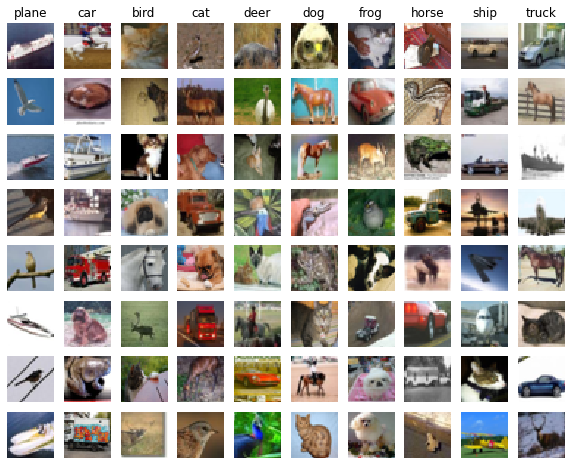

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [18]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10
hidden_size = [60, 80, 100, 120, 200, 300, 400, 500]
learning_rate = [1e-2, 1e-1, 2e-1, 2.5e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1]
reg = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
best_net = None
best_acc = -1
log = {}

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for hs in hidden_size:
    for lr in learning_rate:
        for r in reg:
            net = TwoLayerNet(input_dim, hs, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                              num_iters=3000, batch_size=200,
                              learning_rate=lr, learning_rate_decay=0.95,
                              reg=r, verbose=False)
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            log[(hs, lr, r)] = val_acc
            print('for hs: %e, lr: %e and r: %e, valid accuracy is: %f' % (hs, lr, r, val_acc))
            
            if val_acc > best_acc:
                best_net = net
                best_acc = val_acc
                
                print('Best Networks has an Accuracy of: %f' % best_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


for hs: 6.000000e+01, lr: 1.000000e-02 and r: 1.000000e-08, valid accuracy is: 0.222000
Best Networks has an Accuracy of: 0.222000
for hs: 6.000000e+01, lr: 1.000000e-02 and r: 1.000000e-07, valid accuracy is: 0.223000
Best Networks has an Accuracy of: 0.223000
for hs: 6.000000e+01, lr: 1.000000e-02 and r: 1.000000e-06, valid accuracy is: 0.228000
Best Networks has an Accuracy of: 0.228000
for hs: 6.000000e+01, lr: 1.000000e-02 and r: 1.000000e-05, valid accuracy is: 0.234000
Best Networks has an Accuracy of: 0.234000
for hs: 6.000000e+01, lr: 1.000000e-02 and r: 1.000000e-04, valid accuracy is: 0.228000
for hs: 6.000000e+01, lr: 1.000000e-02 and r: 1.000000e-03, valid accuracy is: 0.204000
for hs: 6.000000e+01, lr: 1.000000e-01 and r: 1.000000e-08, valid accuracy is: 0.526000
Best Networks has an Accuracy of: 0.526000
for hs: 6.000000e+01, lr: 1.000000e-01 and r: 1.000000e-07, valid accuracy is: 0.550000
Best Networks has an Accuracy of: 0.550000
for hs: 6.000000e+01, lr: 1.000000e-01

for hs: 8.000000e+01, lr: 2.500000e-01 and r: 1.000000e-03, valid accuracy is: 0.583000
for hs: 8.000000e+01, lr: 3.000000e-01 and r: 1.000000e-08, valid accuracy is: 0.550000
for hs: 8.000000e+01, lr: 3.000000e-01 and r: 1.000000e-07, valid accuracy is: 0.581000
for hs: 8.000000e+01, lr: 3.000000e-01 and r: 1.000000e-06, valid accuracy is: 0.583000
for hs: 8.000000e+01, lr: 3.000000e-01 and r: 1.000000e-05, valid accuracy is: 0.593000
Best Networks has an Accuracy of: 0.593000
for hs: 8.000000e+01, lr: 3.000000e-01 and r: 1.000000e-04, valid accuracy is: 0.587000
for hs: 8.000000e+01, lr: 3.000000e-01 and r: 1.000000e-03, valid accuracy is: 0.590000
for hs: 8.000000e+01, lr: 4.000000e-01 and r: 1.000000e-08, valid accuracy is: 0.578000
for hs: 8.000000e+01, lr: 4.000000e-01 and r: 1.000000e-07, valid accuracy is: 0.569000
for hs: 8.000000e+01, lr: 4.000000e-01 and r: 1.000000e-06, valid accuracy is: 0.565000
for hs: 8.000000e+01, lr: 4.000000e-01 and r: 1.000000e-05, valid accuracy is

for hs: 1.000000e+02, lr: 7.000000e-01 and r: 1.000000e-06, valid accuracy is: 0.568000
for hs: 1.000000e+02, lr: 7.000000e-01 and r: 1.000000e-05, valid accuracy is: 0.567000
for hs: 1.000000e+02, lr: 7.000000e-01 and r: 1.000000e-04, valid accuracy is: 0.569000
for hs: 1.000000e+02, lr: 7.000000e-01 and r: 1.000000e-03, valid accuracy is: 0.584000
for hs: 1.000000e+02, lr: 8.000000e-01 and r: 1.000000e-08, valid accuracy is: 0.578000
for hs: 1.000000e+02, lr: 8.000000e-01 and r: 1.000000e-07, valid accuracy is: 0.548000
for hs: 1.000000e+02, lr: 8.000000e-01 and r: 1.000000e-06, valid accuracy is: 0.559000
for hs: 1.000000e+02, lr: 8.000000e-01 and r: 1.000000e-05, valid accuracy is: 0.557000
for hs: 1.000000e+02, lr: 8.000000e-01 and r: 1.000000e-04, valid accuracy is: 0.581000
for hs: 1.000000e+02, lr: 8.000000e-01 and r: 1.000000e-03, valid accuracy is: 0.559000
for hs: 1.000000e+02, lr: 9.000000e-01 and r: 1.000000e-08, valid accuracy is: 0.559000
for hs: 1.000000e+02, lr: 9.0000

for hs: 2.000000e+02, lr: 1.000000e-01 and r: 1.000000e-03, valid accuracy is: 0.550000
for hs: 2.000000e+02, lr: 2.000000e-01 and r: 1.000000e-08, valid accuracy is: 0.595000
Best Networks has an Accuracy of: 0.595000
for hs: 2.000000e+02, lr: 2.000000e-01 and r: 1.000000e-07, valid accuracy is: 0.598000
Best Networks has an Accuracy of: 0.598000
for hs: 2.000000e+02, lr: 2.000000e-01 and r: 1.000000e-06, valid accuracy is: 0.584000
for hs: 2.000000e+02, lr: 2.000000e-01 and r: 1.000000e-05, valid accuracy is: 0.581000
for hs: 2.000000e+02, lr: 2.000000e-01 and r: 1.000000e-04, valid accuracy is: 0.604000
Best Networks has an Accuracy of: 0.604000
for hs: 2.000000e+02, lr: 2.000000e-01 and r: 1.000000e-03, valid accuracy is: 0.588000
for hs: 2.000000e+02, lr: 2.500000e-01 and r: 1.000000e-08, valid accuracy is: 0.591000
for hs: 2.000000e+02, lr: 2.500000e-01 and r: 1.000000e-07, valid accuracy is: 0.578000
for hs: 2.000000e+02, lr: 2.500000e-01 and r: 1.000000e-06, valid accuracy is: 

for hs: 3.000000e+02, lr: 5.000000e-01 and r: 1.000000e-07, valid accuracy is: 0.571000
for hs: 3.000000e+02, lr: 5.000000e-01 and r: 1.000000e-06, valid accuracy is: 0.582000
for hs: 3.000000e+02, lr: 5.000000e-01 and r: 1.000000e-05, valid accuracy is: 0.581000
for hs: 3.000000e+02, lr: 5.000000e-01 and r: 1.000000e-04, valid accuracy is: 0.593000
for hs: 3.000000e+02, lr: 5.000000e-01 and r: 1.000000e-03, valid accuracy is: 0.603000
for hs: 3.000000e+02, lr: 6.000000e-01 and r: 1.000000e-08, valid accuracy is: 0.576000
for hs: 3.000000e+02, lr: 6.000000e-01 and r: 1.000000e-07, valid accuracy is: 0.589000
for hs: 3.000000e+02, lr: 6.000000e-01 and r: 1.000000e-06, valid accuracy is: 0.570000
for hs: 3.000000e+02, lr: 6.000000e-01 and r: 1.000000e-05, valid accuracy is: 0.565000
for hs: 3.000000e+02, lr: 6.000000e-01 and r: 1.000000e-04, valid accuracy is: 0.584000
for hs: 3.000000e+02, lr: 6.000000e-01 and r: 1.000000e-03, valid accuracy is: 0.581000
for hs: 3.000000e+02, lr: 7.0000

for hs: 4.000000e+02, lr: 9.000000e-01 and r: 1.000000e-04, valid accuracy is: 0.585000
for hs: 4.000000e+02, lr: 9.000000e-01 and r: 1.000000e-03, valid accuracy is: 0.580000
for hs: 5.000000e+02, lr: 1.000000e-02 and r: 1.000000e-08, valid accuracy is: 0.272000
for hs: 5.000000e+02, lr: 1.000000e-02 and r: 1.000000e-07, valid accuracy is: 0.268000
for hs: 5.000000e+02, lr: 1.000000e-02 and r: 1.000000e-06, valid accuracy is: 0.272000
for hs: 5.000000e+02, lr: 1.000000e-02 and r: 1.000000e-05, valid accuracy is: 0.265000
for hs: 5.000000e+02, lr: 1.000000e-02 and r: 1.000000e-04, valid accuracy is: 0.273000
for hs: 5.000000e+02, lr: 1.000000e-02 and r: 1.000000e-03, valid accuracy is: 0.269000
for hs: 5.000000e+02, lr: 1.000000e-01 and r: 1.000000e-08, valid accuracy is: 0.560000
for hs: 5.000000e+02, lr: 1.000000e-01 and r: 1.000000e-07, valid accuracy is: 0.556000
for hs: 5.000000e+02, lr: 1.000000e-01 and r: 1.000000e-06, valid accuracy is: 0.569000
for hs: 5.000000e+02, lr: 1.0000

In [19]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.589
